In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
transformation = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307, ), (0.3081, ))])

In [3]:
train_dataset = datasets.MNIST('data/', train=True, transform=transformation, download=True)
test_dataset = datasets.MNIST('data/', train=False, transform=transformation, download=True)

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [5]:
sample_data = next(iter(train_loader))

In [6]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

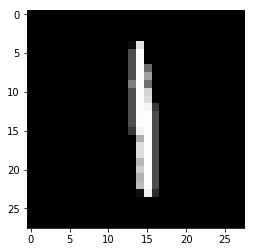

In [7]:
plot_img(sample_data[0][2])

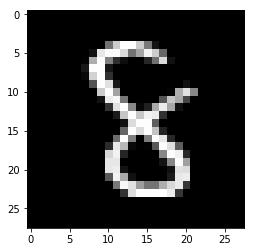

In [8]:
plot_img(sample_data[0][1])

In [9]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [10]:
model = Net()

In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
data, target = next(iter(train_loader))
output = model(Variable(data))

In [12]:
print(output.size())

torch.Size([32, 10])


In [13]:
print(target.size())

torch.Size([32])


In [14]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
        
    running_loss=0.0
    running_correct =0
    
    for batch_idx , (data,target) in enumerate(data_loader):
        data , target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss =F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output, target, size_average=False).data[0]
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        
        if phase =='training':
            loss.backward()
            optimizer.step()
            
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100 * float(running_correct)/len(data_loader.dataset)
    print('{0} loss is {1} and {2} accuracy is {3}/{4} accuarcy is {5}'.format(phase, loss, phase, running_correct, len(data_loader.dataset), accuracy))
    return loss, accuracy

In [15]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

In [16]:
for epoch in range(1, 20):
    print("[*] epoch : ", epoch)
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

[*] epoch :  1


/usr/local/lib/python3.5/dist-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


training loss is 0.6038708090782166 and training accuracy is 48641/60000 accuarcy is 81.06833333333333
validation loss is 0.1602570116519928 and validation accuracy is 9526/10000 accuarcy is 95.26
[*] epoch :  2
training loss is 0.2149556428194046 and training accuracy is 56255/60000 accuarcy is 93.75833333333334
validation loss is 0.09653084725141525 and validation accuracy is 9697/10000 accuarcy is 96.97
[*] epoch :  3
training loss is 0.1625288873910904 and training accuracy is 57123/60000 accuarcy is 95.205
validation loss is 0.08118181675672531 and validation accuracy is 9751/10000 accuarcy is 97.51
[*] epoch :  4
training loss is 0.13531912863254547 and training accuracy is 57602/60000 accuarcy is 96.00333333333333
validation loss is 0.06669854372739792 and validation accuracy is 9781/10000 accuarcy is 97.81
[*] epoch :  5
training loss is 0.12335552275180817 and training accuracy is 57803/60000 accuarcy is 96.33833333333334
validation loss is 0.057314638048410416 and validation 

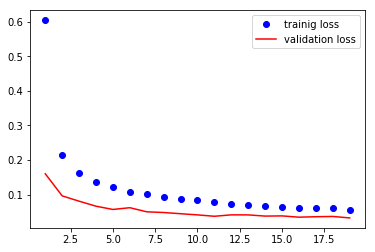

In [17]:
plt.plot(range(1, len(train_losses)+1), train_losses, 'bo', label='trainig loss')
plt.plot(range(1, len(val_losses)+1), val_losses, 'r', label='validation loss')
plt.legend()

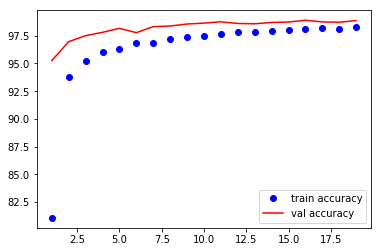

In [18]:
plt.plot(range(1, len(train_accuracy)+1), train_accuracy, 'bo',label='train accuracy')
plt.plot(range(1, len(val_accuracy)+1), val_accuracy, 'r', label='val accuracy')
plt.legend()